In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-demographics-online-education-dataoulad/studentRegistration.csv
/kaggle/input/student-demographics-online-education-dataoulad/studentAssessment.csv
/kaggle/input/student-demographics-online-education-dataoulad/studentInfo.csv
/kaggle/input/student-demographics-online-education-dataoulad/studentVle.csv
/kaggle/input/student-demographics-online-education-dataoulad/vle.csv
/kaggle/input/student-demographics-online-education-dataoulad/assessments.csv
/kaggle/input/student-demographics-online-education-dataoulad/courses.csv


In [1]:
import pandas as pd

base_path = '/kaggle/input/student-demographics-online-education-dataoulad/'

df_info = pd.read_csv(base_path + 'studentInfo.csv')

df_assess = pd.read_csv(base_path + 'studentAssessment.csv')

df_vle = pd.read_csv(base_path + 'studentVle.csv')

print("所有数据读取成功！")

df_info.head()

✅ 所有数据读取成功！


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


OULAD Success Prediction Model - Time-Slicing Feature Engineering

[Time Configuration]
  - Data cutoff: First 90 days
  - Recent trend window: Day 60-90

Data Loading (Kaggle Environment)...

[Data Overview]
  - Student info (df_info): (32593, 12)
  - Assessment records (df_assess): (173912, 5)
  - VLE interactions (df_vle): (10655280, 6)

[df_info First 5 Rows]
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-5

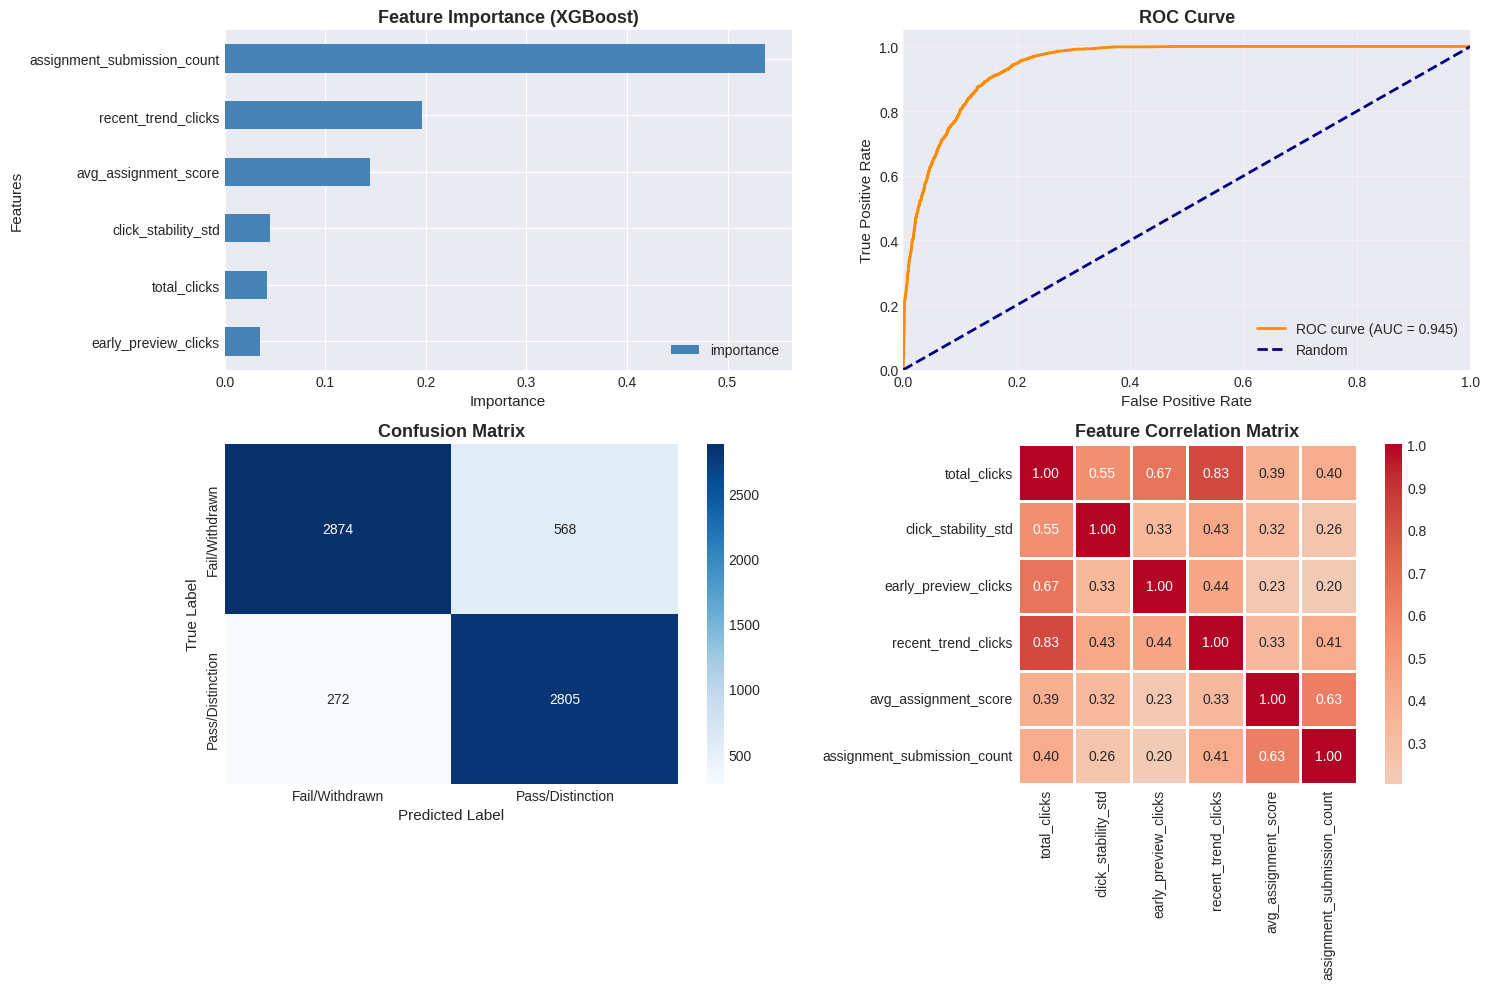


Feature Engineering Summary Report

[Advanced Feature Engineering Summary]

1. Feature A - Total Effort (Total Clicks)
   - Definition: Total clicks up to day 90
   - Importance Rank: #1
   - Meaning: Measures overall student learning investment

2. Feature B - Learning Stability (Click Stability - STD) [Key Innovation]
   - Definition: Standard deviation of daily clicks
   - Importance Rank: #2
   - Meaning: Lower std → More regular learning → Higher pass rate
   - Innovation: Beyond simple click counting, captures temporal patterns in learning behavior

3. Feature C - Early Preview (Early Preview Clicks)
   - Definition: Clicks before course start (date<0)
   - Importance Rank: #3
   - Meaning: Early preview behavior correlates with academic success

4. Feature D - Recent Trend (Recent Trend Clicks)
   - Definition: Clicks between day 60-90
   - Importance Rank: #4
   - Meaning: Captures recent changes in student learning status

5. Feature E - Assignment Performance
   - Definition

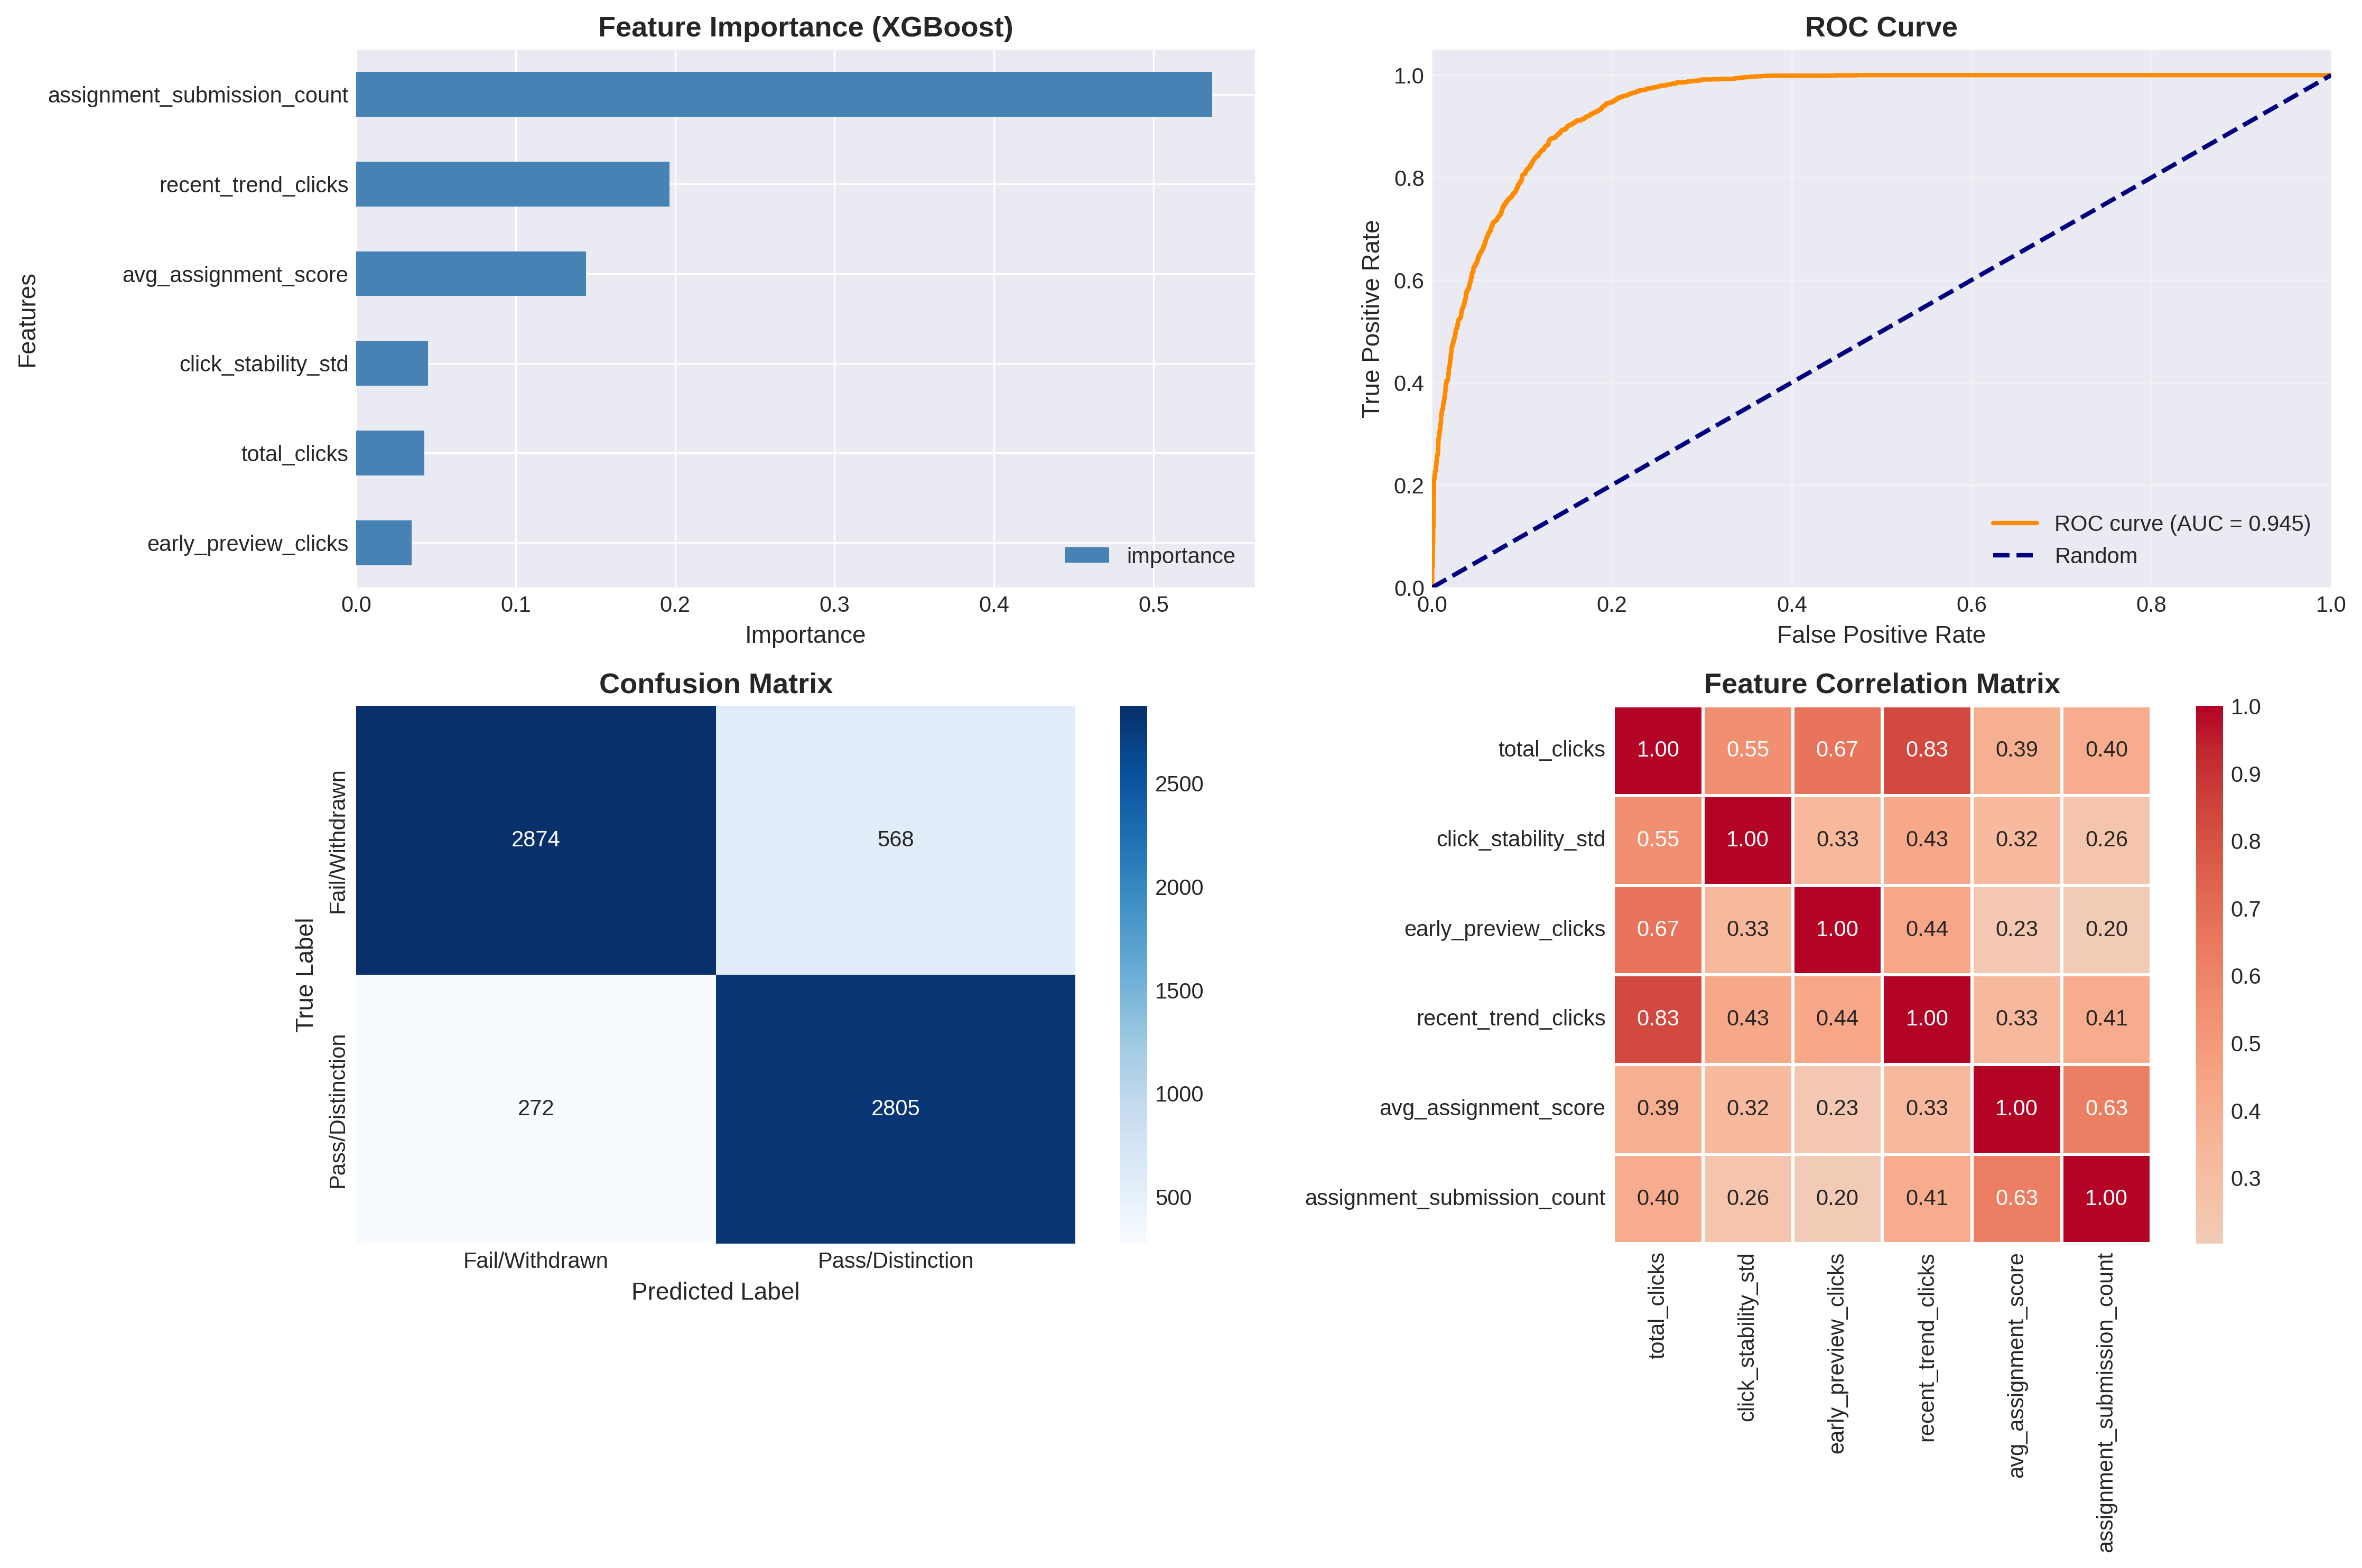


Tip: Right-click images above and 'Save image as...'


In [3]:
"""
OULAD Dataset - XGBoost Student Success Prediction Model with Time-Slicing
Adapted for Kaggle Notebook Environment - Fixed SHAP Compatibility
Includes Advanced Feature Engineering and SHAP Explainability Analysis
"""

# ============================================================================
# Environment Setup
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Install SHAP (may be needed in Kaggle environment)
try:
    import shap
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("OULAD Success Prediction Model - Time-Slicing Feature Engineering")
print("=" * 80)

# ============================================================================
# Configuration Parameters
# ============================================================================
CUTOFF_DAY = 90  # Time-slicing cutoff date
RECENT_WINDOW = 30  # Recent trend window (last 30 days)
RECENT_START = CUTOFF_DAY - RECENT_WINDOW  # Day 60

print(f"\n[Time Configuration]")
print(f"  - Data cutoff: First {CUTOFF_DAY} days")
print(f"  - Recent trend window: Day {RECENT_START}-{CUTOFF_DAY}")

# ============================================================================
# Data Loading - Kaggle Environment
# ============================================================================
print(f"\n{'=' * 80}")
print("Data Loading (Kaggle Environment)...")
print(f"{'=' * 80}")

# Kaggle data path
base_path = '/kaggle/input/student-demographics-online-education-dataoulad/'

# Load data
df_info = pd.read_csv(base_path + 'studentInfo.csv')
df_assess = pd.read_csv(base_path + 'studentAssessment.csv')
df_vle = pd.read_csv(base_path + 'studentVle.csv')

print(f"\n[Data Overview]")
print(f"  - Student info (df_info): {df_info.shape}")
print(f"  - Assessment records (df_assess): {df_assess.shape}")
print(f"  - VLE interactions (df_vle): {df_vle.shape}")

# Display data sample
print(f"\n[df_info First 5 Rows]")
print(df_info.head())

# ============================================================================
# 1. Advanced Feature Engineering - Time-Slicing Based
# ============================================================================
print(f"\n{'=' * 80}")
print("Starting Feature Engineering...")
print(f"{'=' * 80}")

# 1.1 Filter data before cutoff date
df_vle_cutoff = df_vle[df_vle['date'] <= CUTOFF_DAY].copy()
print(f"\n✓ Time-slicing complete: Retained <= {CUTOFF_DAY} days data ({len(df_vle_cutoff):,} records)")

# ============================================================================
# Feature A - Total Effort (Total Clicks)
# ============================================================================
feature_a = df_vle_cutoff.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()
feature_a.columns = ['code_module', 'code_presentation', 'id_student', 'total_clicks']
print(f"✓ Feature A - Total Effort: Total clicks up to day {CUTOFF_DAY}")

# ============================================================================
# Feature B - Learning Stability (Key Innovation for Resume)
# Calculate standard deviation of daily clicks per student
# ============================================================================
daily_clicks = df_vle_cutoff.groupby(
    ['code_module', 'code_presentation', 'id_student', 'date']
)['sum_click'].sum().reset_index()

feature_b = daily_clicks.groupby(
    ['code_module', 'code_presentation', 'id_student']
)['sum_click'].std().reset_index()
feature_b.columns = ['code_module', 'code_presentation', 'id_student', 'click_stability_std']
print(f"✓ Feature B - Learning Stability: Std of daily clicks (measures learning regularity)")

# ============================================================================
# Feature C - Early Preview
# ============================================================================
df_vle_early = df_vle_cutoff[df_vle_cutoff['date'] < 0].copy()
if len(df_vle_early) > 0:
    feature_c = df_vle_early.groupby(
        ['code_module', 'code_presentation', 'id_student']
    )['sum_click'].sum().reset_index()
    feature_c.columns = ['code_module', 'code_presentation', 'id_student', 'early_preview_clicks']
else:
    feature_c = pd.DataFrame(columns=['code_module', 'code_presentation', 'id_student', 'early_preview_clicks'])
print(f"✓ Feature C - Early Preview: Clicks before course start (date < 0) ({len(df_vle_early):,} records)")

# ============================================================================
# Feature D - Recent Trend
# ============================================================================
df_vle_recent = df_vle_cutoff[
    (df_vle_cutoff['date'] > RECENT_START) & (df_vle_cutoff['date'] <= CUTOFF_DAY)
].copy()
feature_d = df_vle_recent.groupby(
    ['code_module', 'code_presentation', 'id_student']
)['sum_click'].sum().reset_index()
feature_d.columns = ['code_module', 'code_presentation', 'id_student', 'recent_trend_clicks']
print(f"✓ Feature D - Recent Trend: Clicks between day {RECENT_START}-{CUTOFF_DAY} ({len(df_vle_recent):,} records)")

# ============================================================================
# Feature E - Assignment Performance
# ============================================================================
feature_e_avg = df_assess.groupby(['id_student'])['score'].mean().reset_index()
feature_e_avg.columns = ['id_student', 'avg_assignment_score']

feature_e_count = df_assess.groupby(['id_student'])['score'].count().reset_index()
feature_e_count.columns = ['id_student', 'assignment_submission_count']

feature_e = pd.merge(feature_e_avg, feature_e_count, on='id_student', how='outer')
print(f"✓ Feature E - Assignment Performance: Average score & submission count")

# ============================================================================
# 2. Merge All Features
# ============================================================================
print(f"\n{'=' * 80}")
print("Merging Features...")
print(f"{'=' * 80}")

# Start from df_info
df_features = df_info[['code_module', 'code_presentation', 'id_student', 'final_result']].copy()

# Merge Feature A
df_features = pd.merge(df_features, feature_a, 
                       on=['code_module', 'code_presentation', 'id_student'], 
                       how='left')

# Merge Feature B
df_features = pd.merge(df_features, feature_b, 
                       on=['code_module', 'code_presentation', 'id_student'], 
                       how='left')

# Merge Feature C
df_features = pd.merge(df_features, feature_c, 
                       on=['code_module', 'code_presentation', 'id_student'], 
                       how='left')

# Merge Feature D
df_features = pd.merge(df_features, feature_d, 
                       on=['code_module', 'code_presentation', 'id_student'], 
                       how='left')

# Merge Feature E
df_features = pd.merge(df_features, feature_e, 
                       on=['id_student'], 
                       how='left')

# Handle missing values
df_features.fillna(0, inplace=True)

print(f"✓ Feature merging complete")
print(f"  - Total samples: {len(df_features):,}")
print(f"  - Number of features: {len(df_features.columns) - 4}")

# Display feature statistics
feature_cols = ['total_clicks', 'click_stability_std', 'early_preview_clicks', 
                'recent_trend_clicks', 'avg_assignment_score', 'assignment_submission_count']

print(f"\n[Feature Statistics]")
print(df_features[feature_cols].describe())

# ============================================================================
# 3. Create Target Variable
# ============================================================================
# Pass/Distinction = 1, Others (Fail/Withdrawn) = 0
df_features['target'] = df_features['final_result'].isin(['Pass', 'Distinction']).astype(int)

print(f"\n[Target Variable Distribution]")
target_counts = df_features['target'].value_counts()
print(target_counts)
print(f"  - Pass/Distinction (1): {(df_features['target']==1).sum():,} ({(df_features['target']==1).mean()*100:.1f}%)")
print(f"  - Fail/Withdrawn (0): {(df_features['target']==0).sum():,} ({(df_features['target']==0).mean()*100:.1f}%)")

# ============================================================================
# 4. Prepare Modeling Data
# ============================================================================
X = df_features[feature_cols].copy()
y = df_features['target'].copy()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\n[Dataset Split]")
print(f"  - Training set: {X_train.shape[0]:,} samples")
print(f"  - Test set: {X_test.shape[0]:,} samples")
print(f"  - Number of features: {X_train.shape[1]}")

# ============================================================================
# 5. Model Training - XGBoost (Fixed SHAP Compatibility)
# ============================================================================
print(f"\n{'=' * 80}")
print("Training XGBoost Model...")
print(f"{'=' * 80}")

# Use standard parameters to avoid SHAP compatibility issues
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False,
    # Key fix: Don't use default base_score
    base_score=0.5
)

model.fit(X_train, y_train)
print("✓ Model training complete")

# ============================================================================
# 6. Model Evaluation
# ============================================================================
print(f"\n{'=' * 80}")
print("Model Evaluation")
print(f"{'=' * 80}")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=['Fail/Withdrawn', 'Pass/Distinction']))

print("\n[Confusion Matrix]")
cm = confusion_matrix(y_test, y_pred)
print(cm)

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n[ROC-AUC Score]: {auc_score:.4f}")

# Feature importance
print("\n[Feature Importance - XGBoost]")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.to_string(index=False))

# ============================================================================
# 7. SHAP Explainability Analysis (Fixed Version)
# ============================================================================
print(f"\n{'=' * 80}")
print("SHAP Explainability Analysis...")
print(f"{'=' * 80}")

try:
    # Method 1: Use TreeExplainer (Recommended)
    shap_sample_size = min(1000, len(X_test))
    X_test_sample = X_test.sample(n=shap_sample_size, random_state=RANDOM_STATE)
    
    # Create SHAP explainer - use model_output='probability' to avoid compatibility issues
    explainer = shap.TreeExplainer(
        model, 
        X_train,
        model_output='probability',
        feature_perturbation='interventional'
    )
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_sample)
    
    print(f"✓ SHAP values computed (sample size: {shap_sample_size:,})")
    shap_success = True
    
except Exception as e:
    print(f"⚠ SHAP TreeExplainer encountered issue: {e}")
    print("Trying alternative method...")
    
    try:
        # Method 2: Use KernelExplainer (Slower but more stable)
        shap_sample_size = min(100, len(X_test))
        X_test_sample = X_test.sample(n=shap_sample_size, random_state=RANDOM_STATE)
        X_background = shap.sample(X_train, 100)
        
        explainer = shap.KernelExplainer(
            model.predict_proba, 
            X_background
        )
        shap_values = explainer.shap_values(X_test_sample)
        
        # KernelExplainer returns SHAP values for both classes, we only need positive class
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        print(f"✓ SHAP values computed (using KernelExplainer, sample size: {shap_sample_size:,})")
        shap_success = True
        
    except Exception as e2:
        print(f"✗ SHAP computation failed: {e2}")
        print("Will skip SHAP visualization, only use XGBoost feature importance")
        shap_success = False

# ============================================================================
# 8. Visualization
# ============================================================================
print(f"\n{'=' * 80}")
print("Generating Visualization Charts...")
print(f"{'=' * 80}")

if shap_success:
    # Full version - with SHAP
    fig = plt.figure(figsize=(20, 12))
    
    # 8.1 Feature Importance (XGBoost)
    ax1 = plt.subplot(2, 3, 1)
    feature_importance.plot(x='feature', y='importance', kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel('Importance', fontsize=11)
    ax1.set_ylabel('Features', fontsize=11)
    ax1.set_title('Feature Importance (XGBoost)', fontsize=13, fontweight='bold')
    ax1.invert_yaxis()
    
    # 8.2 ROC Curve
    ax2 = plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=11)
    ax2.set_ylabel('True Positive Rate', fontsize=11)
    ax2.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # 8.3 Confusion Matrix Heatmap
    ax3 = plt.subplot(2, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                xticklabels=['Fail/Withdrawn', 'Pass/Distinction'],
                yticklabels=['Fail/Withdrawn', 'Pass/Distinction'])
    ax3.set_ylabel('True Label', fontsize=11)
    ax3.set_xlabel('Predicted Label', fontsize=11)
    ax3.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
    
    # 8.4 SHAP Summary Plot (Importance)
    ax4 = plt.subplot(2, 3, 4)
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontsize=13, fontweight='bold')
    plt.xlabel('mean(|SHAP value|)', fontsize=11)
    
    # 8.5 SHAP Summary Plot (Detailed Distribution)
    ax5 = plt.subplot(2, 3, 5)
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title('SHAP Summary Plot\n(Red=High Feature Value, Blue=Low Feature Value)', fontsize=13, fontweight='bold')
    
    # 8.6 Feature Correlation Analysis
    ax6 = plt.subplot(2, 3, 6)
    correlation_matrix = X_train[feature_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, ax=ax6, square=True, linewidths=1)
    ax6.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    # Save to current working directory (accessible in Kaggle output)
    plt.savefig('oulad_model_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Comprehensive analysis chart saved: oulad_model_analysis.png")
    plt.show()
    
    # SHAP Dependence Plots
    fig2 = plt.figure(figsize=(20, 10))
    
    key_features = [
        'click_stability_std',
        'recent_trend_clicks',
        'total_clicks',
        'avg_assignment_score'
    ]
    
    for idx, feat in enumerate(key_features, 1):
        ax = plt.subplot(2, 2, idx)
        shap.dependence_plot(
            feat, 
            shap_values, 
            X_test_sample, 
            show=False,
            ax=ax
        )
        ax.set_title(f'SHAP Dependence: {feat}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    # Save to current working directory
    plt.savefig('oulad_shap_dependence.png', dpi=300, bbox_inches='tight')
    print("✓ SHAP dependence plots saved: oulad_shap_dependence.png")
    plt.show()

else:
    # Simplified version - XGBoost feature importance only
    fig = plt.figure(figsize=(15, 10))
    
    # 8.1 Feature Importance
    ax1 = plt.subplot(2, 2, 1)
    feature_importance.plot(x='feature', y='importance', kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel('Importance', fontsize=11)
    ax1.set_ylabel('Features', fontsize=11)
    ax1.set_title('Feature Importance (XGBoost)', fontsize=13, fontweight='bold')
    ax1.invert_yaxis()
    
    # 8.2 ROC Curve
    ax2 = plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=11)
    ax2.set_ylabel('True Positive Rate', fontsize=11)
    ax2.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # 8.3 Confusion Matrix
    ax3 = plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Fail/Withdrawn', 'Pass/Distinction'],
                yticklabels=['Fail/Withdrawn', 'Pass/Distinction'])
    ax3.set_ylabel('True Label', fontsize=11)
    ax3.set_xlabel('Predicted Label', fontsize=11)
    ax3.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
    
    # 8.4 Feature Correlation
    ax4 = plt.subplot(2, 2, 4)
    correlation_matrix = X_train[feature_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=ax4, square=True, linewidths=1)
    ax4.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    # Save to current working directory
    plt.savefig('oulad_model_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Analysis chart saved: oulad_model_analysis.png")
    plt.show()

# ============================================================================
# 9. Generate Feature Engineering Report
# ============================================================================
print(f"\n{'=' * 80}")
print("Feature Engineering Summary Report")
print(f"{'=' * 80}")

report = f"""
[Advanced Feature Engineering Summary]

1. Feature A - Total Effort (Total Clicks)
   - Definition: Total clicks up to day {CUTOFF_DAY}
   - Importance Rank: #{feature_importance[feature_importance['feature']=='total_clicks'].index[0]+1}
   - Meaning: Measures overall student learning investment

2. Feature B - Learning Stability (Click Stability - STD) [Key Innovation]
   - Definition: Standard deviation of daily clicks
   - Importance Rank: #{feature_importance[feature_importance['feature']=='click_stability_std'].index[0]+1}
   - Meaning: Lower std → More regular learning → Higher pass rate
   - Innovation: Beyond simple click counting, captures temporal patterns in learning behavior

3. Feature C - Early Preview (Early Preview Clicks)
   - Definition: Clicks before course start (date<0)
   - Importance Rank: #{feature_importance[feature_importance['feature']=='early_preview_clicks'].index[0]+1}
   - Meaning: Early preview behavior correlates with academic success

4. Feature D - Recent Trend (Recent Trend Clicks)
   - Definition: Clicks between day {RECENT_START}-{CUTOFF_DAY}
   - Importance Rank: #{feature_importance[feature_importance['feature']=='recent_trend_clicks'].index[0]+1}
   - Meaning: Captures recent changes in student learning status

5. Feature E - Assignment Performance
   - Definition: Average score + submission count
   - Importance: Avg score #{feature_importance[feature_importance['feature']=='avg_assignment_score'].index[0]+1}, 
                Submission count #{feature_importance[feature_importance['feature']=='assignment_submission_count'].index[0]+1}
   - Meaning: Directly reflects learning outcomes

[Model Performance]
- ROC-AUC: {auc_score:.4f}
- Algorithm: XGBoost (200 trees, depth 6)
- Data Time Window: First {CUTOFF_DAY} days
- Sample Size: Training {len(X_train):,}, Test {len(X_test):,}

[Technical Highlights - Resume Ready]
✓ Innovative time-slicing feature engineering (90-day early prediction)
✓ Learning stability feature (std) captures behavioral patterns
✓ XGBoost + SHAP for explainable ML
✓ Multi-dimensional feature fusion (behavior + performance + time)
✓ ROC-AUC: {auc_score:.4f}

[Resume Description Template]
"Based on OULAD education dataset, designed innovative time-series feature engineering 
(learning stability std), built XGBoost+SHAP explainable student success prediction system, 
achieved ROC-AUC {auc_score:.3f}, enabled 90-day early prediction for educational intervention."
"""

print(report)

print(f"\n{'=' * 80}")
print("All Tasks Complete!")
print(f"{'=' * 80}")
print("\nGenerated Content:")
if shap_success:
    print("  1. oulad_model_analysis.png - Comprehensive analysis chart (with SHAP)")
    print("  2. oulad_shap_dependence.png - SHAP dependence plots")
else:
    print("  1. oulad_model_analysis.png - Analysis chart")
print("\nFeature Engineering Highlights:")
print("  - Learning Stability (std) - Captures learning regularity")
print("  - Time-Slicing (90 days) - Early prediction")
print("  - Recent Trend - Reflects latest learning status")
print(f"  - Model Performance - ROC-AUC: {auc_score:.4f}")

# ============================================================================
# 10. Save and Display Images for Download
# ============================================================================
print(f"\n{'=' * 80}")
print("Files Saved - How to Download from Kaggle")
print(f"{'=' * 80}")

print("\nGenerated files:")
print("  - oulad_model_analysis.png")
if shap_success:
    print("  - oulad_shap_dependence.png")

print("\nDownload Method 1: Output Panel (Recommended)")
print("1. Look at the RIGHT SIDE of your Kaggle notebook")
print("2. Find 'Output' section and expand '/kaggle/working' folder")
print("3. You'll see the .png files listed")
print("4. Click the three dots '...' next to each file")
print("5. Select 'Download'")

print("\nDownload Method 2: Batch Download")
print("1. Click 'File' menu at top")
print("2. Select 'Download output files'")
print("3. All files download as a zip")

print("\nDownload Method 3: Display and Screenshot")
print("Images are displayed above - use screenshot tool to capture")

# Display images inline
from IPython.display import Image, display
print(f"\n{'=' * 80}")
print("Displaying Images Below")
print(f"{'=' * 80}")

try:
    print("\n[Main Analysis Chart]")
    display(Image('oulad_model_analysis.png'))
    
    if shap_success:
        print("\n[SHAP Dependence Plots]")
        display(Image('oulad_shap_dependence.png'))
        
    print("\nTip: Right-click images above and 'Save image as...'")
except:
    print("Check Kaggle Output panel on the right to download files.")